# Project 4: Predicting outbreaks caused by West Nile Virus and using cost benefit analysis to help the City of Chicago.

Done by: Richelle-Joy Chia, Er Jie Yong, Meriky Lo 

Problem Statement: How can we help the City of Chicago Public Health Department accurately predict outbreaks and optimize measures to tackle financial burdens caused by WNV related diseases?

## Part 2b: Preprocessing and Modeling with weighted matrix (e.g., trap distance X WNV PDF)

### Importing packages and datasets

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'. We supress the pandas warning on SettingWithCopyWarning 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
import scipy.stats as stats
import os

#to allow for progress tracking
from tqdm import tqdm
tqdm.pandas()

from pycaret.classification import *

In [2]:
# set up mlflow
import mlflow 
mlflow.set_tracking_uri("sqlite:///mlflow.db") 
mlflow.set_experiment("GA-dsi32-project-4-double") 

2022/10/23 19:28:16 INFO mlflow.tracking.fluent: Experiment with name 'GA-dsi32-project-4-double' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/2', creation_time=1666524496404, experiment_id='2', last_update_time=1666524496404, lifecycle_stage='active', name='GA-dsi32-project-4-double', tags={}>

In [3]:
df_train_combined = pd.read_csv('./assets/df_train_combined.csv')
df_test_combined = pd.read_csv('./assets/df_test_combined.csv')
s7 = pd.read_csv('s7_model.csv')
matrix = pd.read_csv('./assets/trap_distance_matrix.csv')

## Set up Test data

In [54]:
s7.columns = ['Id','wnv_pred']

In [55]:
#update 
df_test_combined = pd.concat([df_test_combined, s7['wnv_pred']], axis =1)

In [ ]:
matrix.set_index('Trap', inplace = True)

In [6]:
matrix.fillna(0, inplace = True)

In [7]:
def custom_scaler(series):
    #to scale all the nearby station in terms of distance to a scale of 1
    total = series.sum()
    return series.apply(lambda x: x/total)

In [8]:
for col in matrix.columns[1:]:
    matrix[col] = custom_scaler(matrix[col])

In [21]:
# Create new column that sums the probability of nearby stations based on its weight matrix taking into considerations date, species, trap
df_test_combined['neigh_wnv'] = 0
for row in range(len(df_test_combined)):
    date_focus = df_test_combined['Date'][row]
    trap_focus = df_test_combined['Trap'][row]
    species_focus = df_test_combined['Species'][row]

    temp_df = df_test_combined[['Date','Species','Trap','WnvPresent']][(df_test_combined['Date']==date_focus)&(df_test_combined['Species']==species_focus)]
    
    sum = 0
    for index, val in matrix[trap_focus].iteritems():
        if val > 0:
            sum += temp_df['WnvPresent'][temp_df['Trap']==index].values[0]*val
    
    df_test_combined['neigh_wnv'][row] = sum

## Set up train data

In [33]:
loaded_model = load_model('s7_model_ensemble')


Transformation Pipeline and Model Successfully Loaded


In [34]:
df_train_combined['wnv_pred'] = [one for zero, one in loaded_model.predict_proba(df_train_combined)]

In [35]:
df_train_combined

,New_ID,Date,Week,Month,Year,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,species_no,Station,Tmax,Tmin,Tavg,WetBulb,Heat,Cool,Sunrise,Sunset,WetDry,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Day,Tdiff,SunMins,Humidity,trap_sprayed,days_from_jun1,norm,neigh_mosq_sum,multi_Tavg,multi_WetBulb,multi_PrecipTotal,multi_AvgSpeed,multi_Humidity,multi_SunMins,overall_norm,wnv_pred,neigh_wnv
0,1,2007-05-29,22,5,2007,CULEX PIPIENS,T096,41.731922,-87.677512,1,0,2.0,2,88,65,77,66.0,5.0,5.0,1900-01-01 04:21:00,1900-01-01 19:17:00,1,0.0,29.44,30.09,5.8,16,7.4,29,76.5,896.0,50.0,0,0,7.692862e-10,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,0.001521,0.0
1,2,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0,2.0,2,88,65,77,66.0,5.0,5.0,1900-01-01 04:21:00,1900-01-01 19:17:00,1,0.0,29.44,30.09,5.8,16,7.4,29,76.5,896.0,50.0,0,0,6.615687e-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,0.000195,0.0
2,3,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T050,41.919343,-87.694259,1,0,2.0,2,88,65,77,66.0,5.0,5.0,1900-01-01 04:21:00,1900-01-01 19:17:00,1,0.0,29.44,30.09,5.8,16,7.4,29,76.5,896.0,50.0,0,0,6.615687e-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,0.000096,0.0
3,4,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T054,41.921965,-87.632085,2,0,2.0,2,88,65,77,66.0,5.0,5.0,1900-01-01 04:21:00,1900-01-01 19:17:00,1,0.0,29.44,30.09,5.8,16,7.4,29,76.5,896.0,50.0,0,0,6.615687e-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,0.000008,0.0
4,5,2007-05-29,22,5,2007,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,1,0,2.0,2,88,65,77,66.0,5.0,5.0,1900-01-01 04:21:00,1900-01-01 19:17:00,1,0.0,29.44,30.09,5.8,16,7.4,29,76.5,896.0,50.0,0,0,6.615687e-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,0.001650,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8470,8471,2013-09-26,38,9,2013,CULEX RESTUANS,T048,41.867108,-87.654224,7,0,1.0,2,75,55,65,58.0,9.0,9.0,1900-01-01 05:43:00,1900-01-01 17:42:00,0,0.0,29.40,30.04,4.1,9,4.6,26,65.0,719.0,63.9,0,118,1.042850e-02,0.0,65.0,58.0,0.0,4.6,63.9,719.0,0.035536,0.002856,0.0
8471,8472,2013-09-26,38,9,2013,CULEX RESTUANS,T082,41.803423,-87.642984,2,0,1.0,2,75,55,65,58.0,9.0,9.0,1900-01-01 05:43:00,1900-01-01 17:42:00,0,0.0,29.40,30.04,4.1,9,4.6,26,65.0,719.0,63.9,0,118,1.042850e-02,0.0,65.0,58.0,0.0,4.6,63.9,719.0,0.035536,0.017943,0.0
8472,8473,2013-09-26,38,9,2013,CULEX RESTUANS,T102,41.750498,-87.605294,1,0,1.0,2,75,55,65,58.0,9.0,9.0,1900-01-01 05:43:00,1900-01-01 17:42:00,0,0.0,29.40,30.04,4.1,9,4.6,26,65.0,719.0,63.9,0,118,1.042850e-02,0.0,65.0,58.0,0.0,4.6,63.9,719.0,0.035536,0.001465,0.0
8473,8474,2013-09-26,38,9,2013,CULEX RESTUANS,T209,41.740641,-87.546587,1,0,1.0,2,75,55,65,58.0,9.0,9.0,1900-01-01 05:43:00,1900-01-01 17:42:00,0,0.0,29.40,30.04,4.1,9,4.6,26,65.0,719.0,63.9,0,118,1.042850e-02,0.0,65.0,58.0,0.0,4.6,63.9,719.0,0.035536,0.004817,0.0


In [36]:
# Create new column that sums the probability of nearby stations based on its weight matrix taking into considerations date, species, trap
df_train_combined['neigh_wnv'] = 0
for row in range(len(df_train_combined)):
    date_focus = df_train_combined['Date'][row]
    trap_focus = df_train_combined['Trap'][row]
    species_focus = df_train_combined['Species'][row]

    temp_df = df_train_combined[['Date','Species','Trap','WnvPresent']][(df_train_combined['Date']==date_focus)&(df_train_combined['Species']==species_focus)]
    sum = 0
    for index, val in matrix[trap_focus].iteritems():
        if val > 0:
            if len(temp_df['WnvPresent'][temp_df['Trap']==index]) > 0:
                sum += temp_df['WnvPresent'][temp_df['Trap']==index].values[0]*val
    
    df_train_combined['neigh_wnv'][row] = sum

# Modeling

In [41]:
cols_to_drop = [
    'New_ID',
    'Tmax',
    'Tmin',
    'Heat',
    'Cool', 
    'Sunrise',
    'Sunset',
    'Tdiff',
    'ResultSpeed',
    'ResultDir',
]

In [42]:
df_train_combined.drop(cols_to_drop, axis = 1, inplace = True)
df_test_combined.drop(cols_to_drop, axis = 1, inplace = True)

In [47]:
# Saving predicted value for models
def predict_save(model, filename, testdf):
    save_model(model, filename)
    loaded_model = load_model(filename)
    df_submit = pd.DataFrame(zip(list(df_test_combined['Id']), [one for zero, one in loaded_model.predict_proba(testdf)]),columns = ['Id','WnvPresent'])
    df_submit.to_csv(path_or_buf = './models/'+filename+'.csv', index=False)
    print(f"{filename}.csv has been saved in {os.getcwd()}")
    return df_submit

# SS1
Use the parameter from previous S7 model

In [46]:
categorical_features = ['Trap', 'Station', 'species_no']
date_features = ['Date']
ignore_features = ['Species', 'neigh_mosq_sum', 'NumMosquitos', 'Tavg', 'WetBulb', 'PrecipTotal', 'AvgSpeed', 'Humidity', 'SunMins', 'Year','Month','Day','WetDry','trap_sprayed']

In [48]:
ss1 = setup(df_train_combined,
           target = 'WnvPresent',
           use_gpu = True,
           categorical_features = categorical_features,
           date_features = date_features,
           ignore_features = ignore_features,
           data_split_shuffle = False,
           transformation = True,
           pca = True,
           remove_multicollinearity = True,
           fix_imbalance = True,
           log_experiment = True,
           experiment_name = 'GA-dsi32-project-4-double',
           silent = True,
           session_id = 42,
          )

,Description,Value
0,session_id,42
1,Target,WnvPresent
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8475, 35)"
5,Missing Values,True
6,Numeric Features,16
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [49]:
ss1_model = compare_models(sort = 'AUC')
print(ss1_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.6777,0.8084,0.7627,0.2281,0.2699,0.2192,0.2821,0.1330
ada,Ada Boost Classifier,0.7193,0.7840,0.5250,0.2804,0.2148,0.1661,0.2143,3.9840
lr,Logistic Regression,0.6902,0.7740,0.6940,0.3148,0.2660,0.2175,0.2872,0.1950
gbc,Gradient Boosting Classifier,0.7222,0.7286,0.4149,0.2991,0.1675,0.1176,0.1638,19.9590
qda,Quadratic Discriminant Analysis,0.7960,0.7119,0.5362,0.2743,0.2756,0.2308,0.2667,0.0910
lightgbm,Light Gradient Boosting Machine,0.7820,0.6859,0.2478,0.2014,0.1035,0.0591,0.0838,0.8640
nb,Naive Bayes,0.6438,0.6732,0.5402,0.0697,0.1206,0.0547,0.0866,0.0380
rf,Random Forest Classifier,0.8577,0.5869,0.1589,0.1590,0.0903,0.0578,0.0710,1.2830
et,Extra Trees Classifier,0.8522,0.5261,0.1502,0.2518,0.0820,0.0468,0.0739,0.6720
dummy,Dummy Classifier,0.9606,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0260


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
CPU times: total: 5min 26s
Wall time: 5min 1s


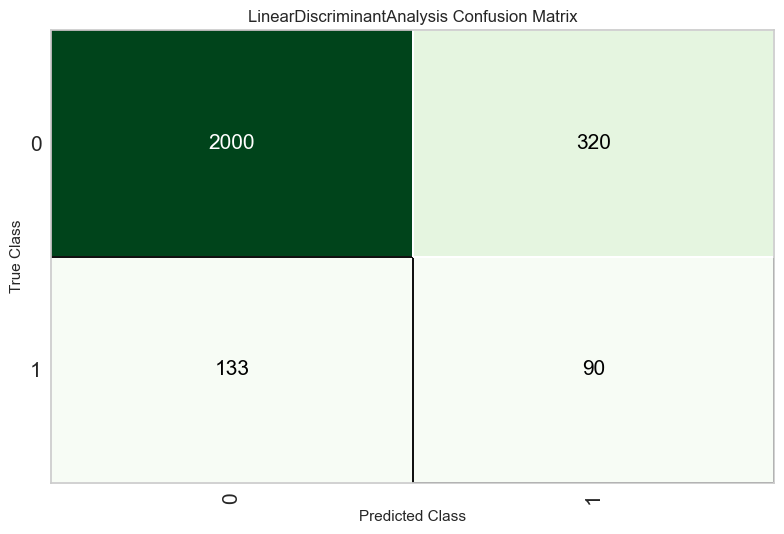

In [50]:
plot_model(ss1_model, plot = 'confusion_matrix')

In [58]:
predict_save(ss1_model,'ss1_model', df_test_combined)

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
ss1_model.csv has been saved in C:\Users\kyunomi\Documents\GA\project4 (1)


,Id,WnvPresent
0,1,0.022816
1,2,0.019517
2,3,0.022810
3,4,0.045012
4,5,0.045012
...,...,...
116288,116289,0.009355
116289,116290,0.009359
116290,116291,0.009364
116291,116292,0.006447


# SS2
Use the parameter from previous S7 model
Only put in `wnv_pred` and `neigh_wnv` as X

In [59]:
df_train_weighted = df_train_combined[['wnv_pred','neigh_wnv','WnvPresent']]

In [60]:
df_test_weighted = df_test_combined[['wnv_pred','neigh_wnv']]

In [61]:
ss1 = setup(df_train_weighted,
           target = 'WnvPresent',
           use_gpu = True,
           data_split_shuffle = False,
           transformation = True,
           pca = True,
           remove_multicollinearity = True,
           log_experiment = True,
           experiment_name = 'GA-dsi32-project-4-double',
           silent = True,
           session_id = 42,
          )

,Description,Value
0,session_id,42
1,Target,WnvPresent
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8475, 3)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [62]:
ss2_model = compare_models(sort = 'AUC')
print(ss2_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7218,0.9305,0.9500,0.3224,0.4018,0.3581,0.4336,0.0160
lr,Logistic Regression,0.7630,0.9299,0.9332,0.3681,0.4361,0.3959,0.4689,0.0220
qda,Quadratic Discriminant Analysis,0.7566,0.9210,0.9330,0.3555,0.4278,0.3869,0.4586,0.0120
nb,Naive Bayes,0.7775,0.9168,0.9038,0.3799,0.4460,0.4072,0.4722,0.0120
gbc,Gradient Boosting Classifier,0.8188,0.9088,0.8603,0.3970,0.4534,0.4161,0.4798,0.6710
ada,Ada Boost Classifier,0.7856,0.9059,0.9154,0.3597,0.4389,0.3991,0.4678,0.2420
lightgbm,Light Gradient Boosting Machine,0.8184,0.8904,0.7960,0.3918,0.4411,0.4031,0.4546,0.6210
rf,Random Forest Classifier,0.8039,0.8334,0.6415,0.3021,0.3369,0.2923,0.3332,0.4520
knn,K Neighbors Classifier,0.8152,0.8283,0.6761,0.3545,0.3744,0.3333,0.3788,0.0500
et,Extra Trees Classifier,0.8026,0.7903,0.6326,0.2889,0.3266,0.2816,0.3219,0.7120


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


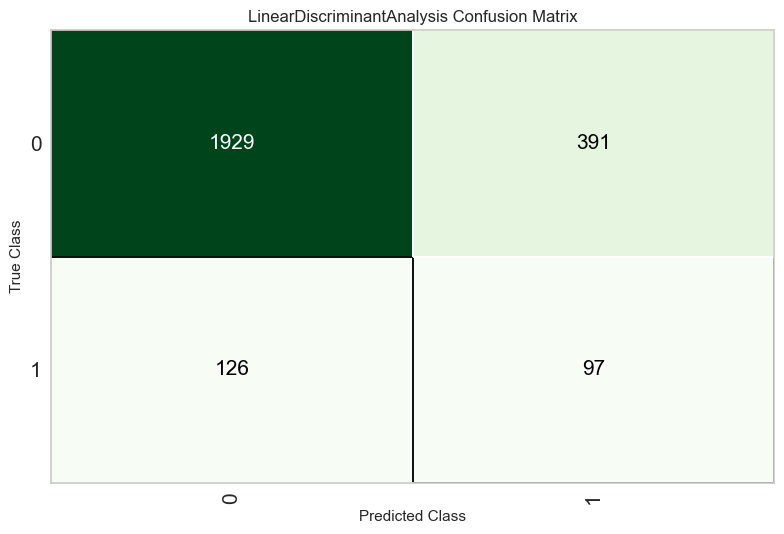

In [63]:
plot_model(ss2_model, plot = 'confusion_matrix')

In [64]:
predict_save(ss2_model,'ss2_model', df_test_weighted)

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
ss2_model.csv has been saved in C:\Users\kyunomi\Documents\GA\project4 (1)


,Id,WnvPresent
0,1,0.008433
1,2,0.007947
2,3,0.008432
3,4,0.007779
4,5,0.007779
...,...,...
116288,116289,0.007895
116289,116290,0.007899
116290,116291,0.007902
116291,116292,0.007857


In [65]:
ss2_model_tuned = tune_model(ss2_model, optimize='AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9832,0.9948,0.8750,0.7500,0.8077,0.7989,0.8015
1,0.4747,0.9279,1.0000,0.0714,0.1333,0.0626,0.1798
2,0.1585,0.6878,1.0000,0.0441,0.0844,0.0109,0.0741
3,0.5261,0.9159,1.0000,0.0757,0.1407,0.0739,0.1959
4,0.9528,0.9995,1.0000,0.4510,0.6216,0.6003,0.6548
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.7656,0.9566,1.0000,0.1420,0.2486,0.1939,0.3276
7,0.8449,0.9670,1.0000,0.2000,0.3333,0.2873,0.4095
8,0.9477,0.9603,0.6250,0.4054,0.4918,0.4656,0.4777


In [66]:
ss2_model_ensemble = ensemble_model(ss2_model_tuned, optimize='AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9832,0.9948,0.8750,0.7500,0.8077,0.7989,0.8015
1,0.4747,0.9275,1.0000,0.0714,0.1333,0.0626,0.1798
2,0.1585,0.6878,1.0000,0.0441,0.0844,0.0109,0.0741
3,0.5261,0.9159,1.0000,0.0757,0.1407,0.0739,0.1959
4,0.9528,0.9995,1.0000,0.4510,0.6216,0.6003,0.6548
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.7639,0.9568,1.0000,0.1411,0.2473,0.1924,0.3263
7,0.8449,0.9670,1.0000,0.2000,0.3333,0.2873,0.4095
8,0.9477,0.9603,0.6250,0.4054,0.4918,0.4656,0.4777


In [67]:
predict_save(ss2_model_ensemble,'ss2_model_ensemble', df_test_weighted)

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
ss2_model_ensemble.csv has been saved in C:\Users\kyunomi\Documents\GA\project4 (1)


,Id,WnvPresent
0,1,0.007440
1,2,0.007007
2,3,0.007440
3,4,0.006858
4,5,0.006858
...,...,...
116288,116289,0.006952
116289,116290,0.006954
116290,116291,0.006957
116291,116292,0.006920


Conclusion: As SS2 model produces the best results and obtain the highest kaggle private score of 0.70935 and public score of 0.72172, we will proceed to confirm SS2 model as the selected model

## Time to move on to the cost benefit analysis in the next notebook.